In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import dash
from dash import dcc, html
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pylab as pl 

In [2]:
path = r'C:\Users\poury\02-2024 Auto Scout'

In [3]:
# Load the dataset
df = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'auto_scout.csv'))

In [4]:
df.head()

,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,2.0 V6 TB
1,1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,NaN,- (g/km),190000.0,"Q4 Allrad, 3.2L GTA"
2,2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,NaN,- (g/km),129000.0,ALFA ROME 916
3,3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,2.0 16V Twin Spark L
4,4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,"3.0i Super V6, absoluter Topzustand !"


In [5]:
df.shape

(251079, 15)

In [6]:
#Missing values
df.isnull().sum()

Unnamed: 0                      0
brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    26873
fuel_consumption_g_km           0
mileage_in_km                 152
offer_description               1
dtype: int64

In [7]:
# Convert 'year' column to int type
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Set mileage to 0 for rows with empty mileage and year 2022 or 2023
df.loc[(df['mileage_in_km'].isna()) & ((df['year'] == 2022) | (df['year'] == 2023)), 'mileage_in_km'] = 0

In [8]:
#Deleting not usefull columns
df_2 = df.drop(columns=['Unnamed: 0','offer_description','registration_date','fuel_consumption_g_km','power_kw'])

In [9]:
# Convert 'power_ps' column to numeric type
df_2['power_ps'] = pd.to_numeric(df['power_ps'], errors='coerce')

# Fill missing values in 'fuel_consumption_l_100km' based on similar model and power_ps
df_2['fuel_consumption_l_100km'] = df.groupby(['model', 'power_ps'])['fuel_consumption_l_100km'].transform(lambda x: x.fillna(method='ffill'))


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\956905520.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_2['fuel_consumption_l_100km'] = df.groupby(['model', 'power_ps'])['fuel_consumption_l_100km'].transform(lambda x: x.fillna(method='ffill'))


In [10]:
df_2.head()

,brand,model,color,year,price_in_euro,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km
0,alfa-romeo,Alfa Romeo GTV,red,1995.0,1300,201.0,Manual,Petrol,"10,9 l/100 km",160500.0
1,alfa-romeo,Alfa Romeo 164,black,1995.0,24900,260.0,Manual,Petrol,NaN,190000.0
2,alfa-romeo,Alfa Romeo Spider,black,1995.0,5900,150.0,Unknown,Petrol,NaN,129000.0
3,alfa-romeo,Alfa Romeo Spider,black,1995.0,4900,150.0,Manual,Petrol,"9,5 l/100 km",189500.0
4,alfa-romeo,Alfa Romeo 164,red,1996.0,17950,179.0,Manual,Petrol,"7,2 l/100 km",96127.0


In [11]:
def transform_price(price):
    try:
        return int(price)
    except:
        return np.NaN

In [12]:
# Convert 'power_ps' column to numeric type, coercing errors to NaN
df_2['power_ps'] = pd.to_numeric(df_2['power_ps'], errors='coerce')

# Set values outside the range [50, 1000] to NaN
df_2['power_ps'] = df_2['power_ps'].apply(lambda x: x if 50 <= x <= 1000 else np.nan)


In [13]:
# Convert 'year' column to numeric type, coercing errors to NaN
df_2['year'] = pd.to_numeric(df_2['year'], errors='coerce')

# Set values outside the range [1900, 2024] to NaN
df_2['year'] = df_2['year'].apply(lambda x: x if 1900 <= x <= 2024 else np.nan)


In [14]:
#changing 'price' to numeric  type
df_2['price_in_euro'] = pd.to_numeric(df_2['price_in_euro'], errors='coerce')
#setting  the appropriate range for it
df['price_in_euro'] = df_2['price_in_euro'].apply(lambda x: x if 0 <=x <=3000000 else np.nan)

In [15]:
#changing transmission types to only two type
def format_transmission(transmission):
    if transmission == 'Unknown':
        return np.NaN
    elif transmission == 'Semi-automatic':
        return 'Automatic'
    else:
        return transmission

# Apply the function to the 'transmission' column
df_2['transmission_type'] = df_2['transmission_type'].apply(format_transmission)

In [16]:
df_2['transmission_type'].value_counts()

transmission_type
Automatic    132066
Manual       117869
Name: count, dtype: int64

In [17]:
#fuel type column
fuels = ['Petrol','Diesel','Diesel Hybrid','Hybrid','Electric','LPG','CNG','Hydrogen']

In [18]:
def format_fuel(fuel):
    if fuel in fuels:
        return fuel
    else:
        return np.NaN
    # Apply the function to the 'transmission' column
df_2['fuel_type'] = df_2['fuel_type'].apply(format_fuel)

In [19]:
import re

def extract_float(value):
    if pd.isnull(value):
        return np.NaN
    # Use regular expression to extract the float number
    match = re.match(r'(\d+,\d+)', value)
    if match:
        return match.group(1)
    else:
        return np.NaN

# Apply the function to the 'fuel_consumption_l_100km' column
df_2['fuel_consumption_l_100km'] = df_2['fuel_consumption_l_100km'].apply(extract_float)

In [20]:
# Fill missing values in 'fuel_consumption_l_100km' based on similar model and power_ps
df_2['fuel_consumption_l_100km'] = df_2.groupby(['model', 'power_ps'])['fuel_consumption_l_100km'].transform(lambda x: x.fillna(method='ffill'))

C:\Users\poury\AppData\Local\Temp\ipykernel_13444\449036869.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_2['fuel_consumption_l_100km'] = df_2.groupby(['model', 'power_ps'])['fuel_consumption_l_100km'].transform(lambda x: x.fillna(method='ffill'))


In [21]:
df_2['fuel_type'].value_counts()

fuel_type
Petrol           143280
Diesel            86421
Hybrid            12607
Electric           5967
LPG                1255
CNG                 508
Diesel Hybrid       476
Hydrogen             82
Name: count, dtype: int64

In [22]:
df_2.isna().sum()

brand                          0
model                          0
color                        166
year                         199
price_in_euro                199
power_ps                     447
transmission_type           1144
fuel_type                    483
fuel_consumption_l_100km    9861
mileage_in_km                 90
dtype: int64

In [23]:
df_cleaned = df_2.dropna()

In [24]:
df_cleaned.isna().sum()

brand                       0
model                       0
color                       0
year                        0
price_in_euro               0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
mileage_in_km               0
dtype: int64

In [25]:
# Define the reference year from which to calculate the car age
reference_year = 2024  # Change this to your desired year

# Calculate the car age
df_cleaned['age'] = reference_year - df_cleaned['year']

C:\Users\poury\AppData\Local\Temp\ipykernel_13444\3150273380.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['age'] = reference_year - df_cleaned['year']


In [26]:
# Export data to csv

df_cleaned.to_csv(os.path.join(path, '02 Data','Prepared Data', 'Auto Scout Cleaned.csv'))

In [27]:
df_cleaned.shape

(239811, 11)

In [28]:
df_cleaned['model'].value_counts()

model
Volkswagen Golf    7423
Opel Astra         4313
Opel Corsa         4188
SEAT Leon          4088
Ford Focus         3825
                   ... 
Infiniti QX60         1
BMW XM                1
Infiniti QX80         1
Citroen               1
Infiniti M37          1
Name: count, Length: 1166, dtype: int64

In [29]:
# Calculate the value counts for the 'models' column
model_counts = df_cleaned['model'].value_counts()

# Filter out models with count less than 10
rare_models = model_counts[model_counts < 10].index

# Filter the DataFrame to exclude rows with rare models
df_filtered = df_cleaned[~df_cleaned['model'].isin(rare_models)]

In [30]:
df_filtered

,brand,model,color,year,price_in_euro,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,age
0,alfa-romeo,Alfa Romeo GTV,red,1995.0,1300.0,201.0,Manual,Petrol,"10,9",160500.0,29.0
3,alfa-romeo,Alfa Romeo Spider,black,1995.0,4900.0,150.0,Manual,Petrol,"9,5",189500.0,29.0
5,alfa-romeo,Alfa Romeo Spider,red,1996.0,7900.0,150.0,Manual,Petrol,"9,5",47307.0,28.0
9,alfa-romeo,Alfa Romeo Spider,black,1996.0,6976.0,150.0,Manual,Petrol,"9,2",99000.0,28.0
10,alfa-romeo,Alfa Romeo Spider,silver,1996.0,5499.0,192.0,Manual,Petrol,"11,1",157000.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...
251073,volvo,Volvo XC60,silver,2023.0,54500.0,197.0,Automatic,Diesel,"5,6",5900.0,1.0
251074,volvo,Volvo XC40,white,2023.0,57990.0,261.0,Automatic,Hybrid,"1,8",1229.0,1.0
251075,volvo,Volvo XC90,white,2023.0,89690.0,235.0,Automatic,Diesel,"7,6",4900.0,1.0
251076,volvo,Volvo V60,white,2023.0,61521.0,197.0,Automatic,Diesel,"4,7",1531.0,1.0


In [31]:
# Replace commas with periods and convert to float
df_filtered['fuel_consumption_l_100km'] = df_filtered['fuel_consumption_l_100km'].str.replace(',', '.').astype(float)

C:\Users\poury\AppData\Local\Temp\ipykernel_13444\1248186907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['fuel_consumption_l_100km'] = df_filtered['fuel_consumption_l_100km'].str.replace(',', '.').astype(float)


# EDA

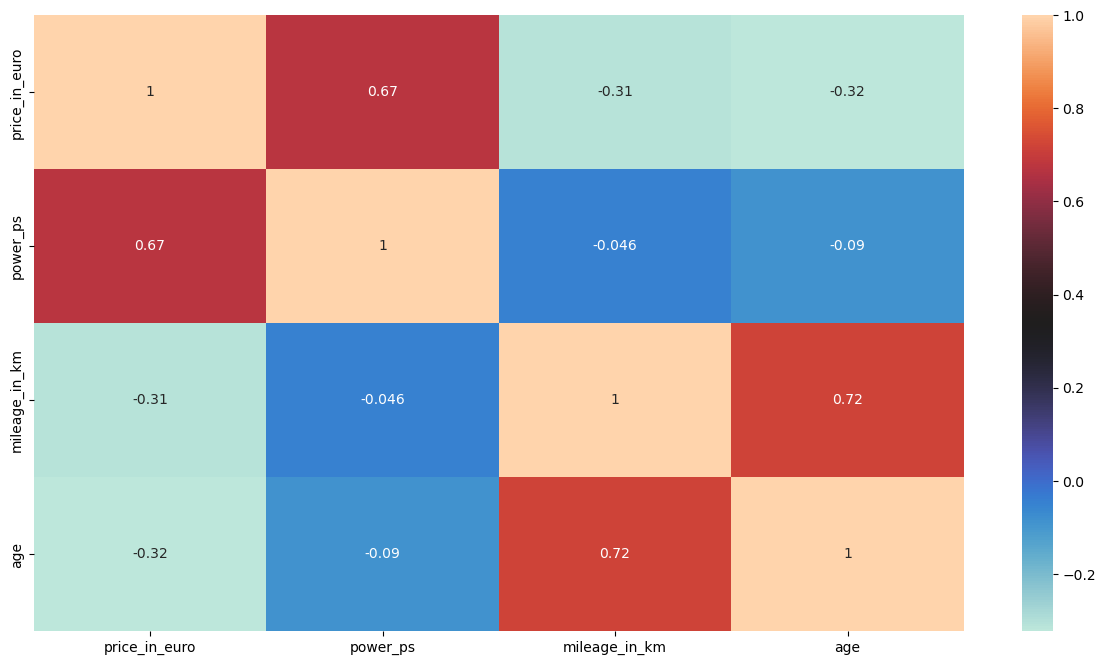

In [32]:
plt.figure(figsize=(15,8))
sns.heatmap(df_filtered[['price_in_euro','power_ps','mileage_in_km','age']].corr(), annot=True, cmap='icefire')
plt.savefig('path_to_save_correlation_plot.png')  # Save the plot
plt.show()

# Save correlation data to a CSV file
correlation_data = df_filtered[['price_in_euro','power_ps','mileage_in_km','age']].corr()
correlation_data.to_csv('path_to_save_correlation_data.csv')

Age Distribution

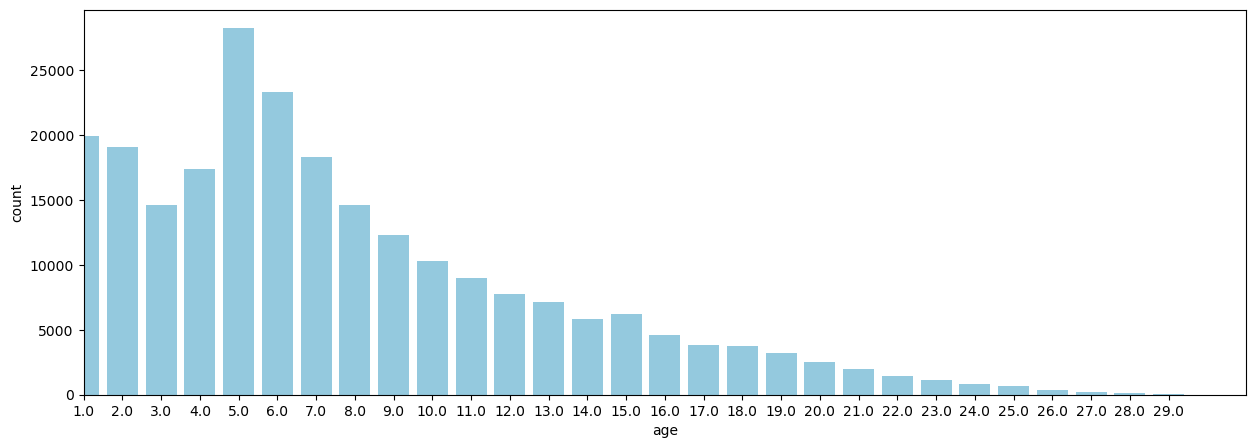

In [33]:
# Define a custom skyblue color palette
custom_palette = sns.color_palette(["skyblue"]) # Create the plot
# Create the plot
plt.figure(figsize=(15, 5))
sns.countplot(data=df_filtered, x='age', palette=custom_palette)
plt.xlim(0, 30)  # Set x-axis limit if needed
plt.savefig(os.path.join(path, '04 Visualizations', 'age.png'))
plt.show()

Mileage Distribution

E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


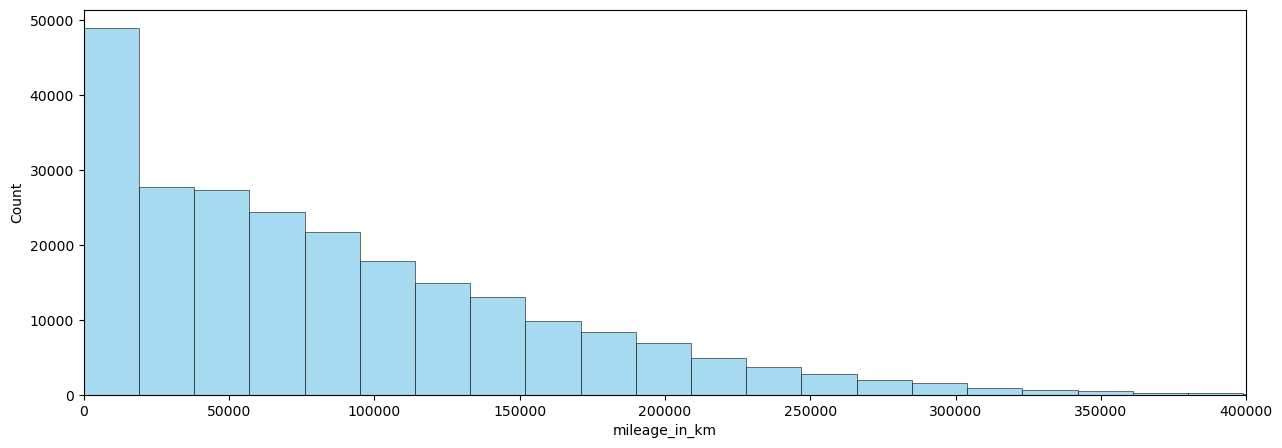

In [34]:
plt.figure(figsize=(15, 5))
sns.histplot(df_filtered, x='mileage_in_km', bins=200,color='skyblue')
plt.xlim(0, 400000)
plt.savefig(os.path.join(path, '04 Visualizations', 'mileage.png'))
plt.show()

Price Distribution

E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


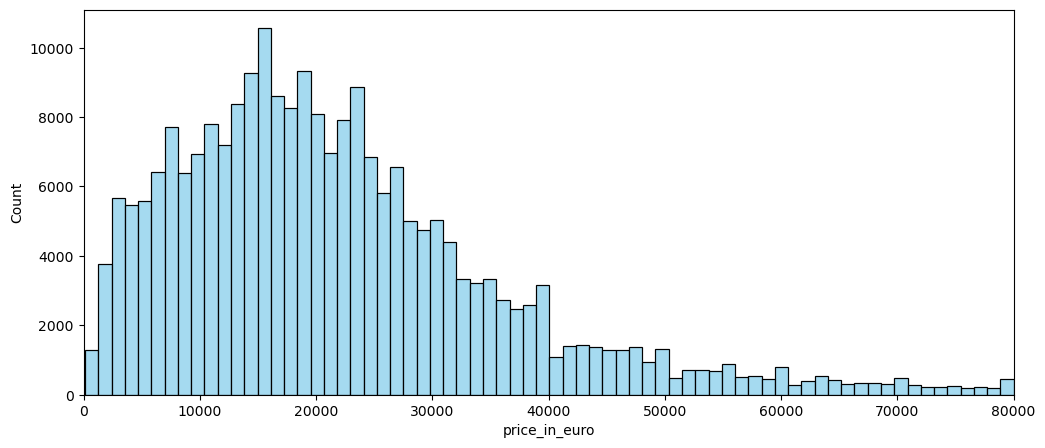

In [35]:
plt.figure(figsize=(12,5))
sns.histplot(data=df_filtered[df_filtered['price_in_euro']<80000],x='price_in_euro',bins=70,color='skyblue')
plt.xlim(0, 80000)
plt.savefig(os.path.join(path, '04 Visualizations', 'price.png'))
plt.show()

Horse Power Distribution

E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


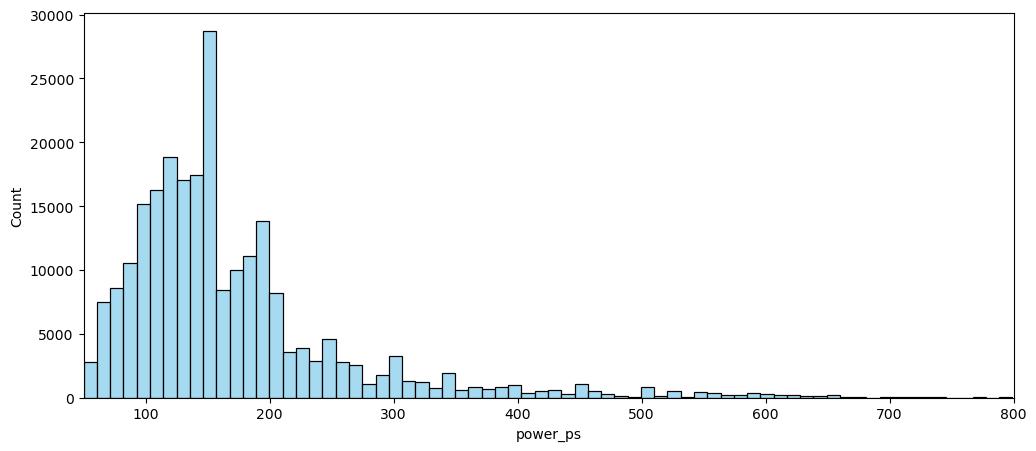

In [36]:
plt.figure(figsize=(12,5))
sns.histplot(data=df_filtered[df_filtered['power_ps']<800],x='power_ps',bins=70,color='skyblue')
plt.xlim(50, 800)
plt.savefig(os.path.join(path, '04 Visualizations', 'Power.png'))
plt.show()

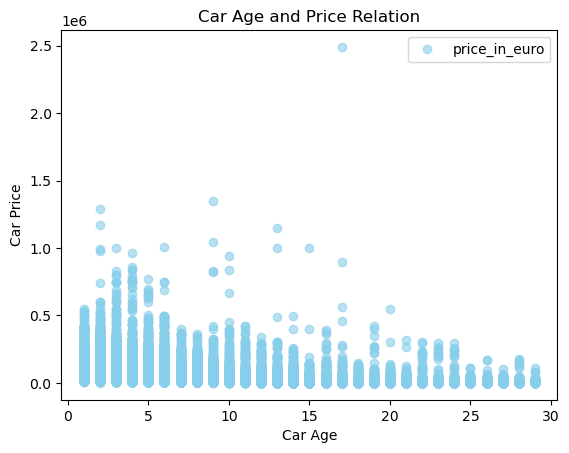

In [37]:
df_filtered.plot(x = 'age', y= 'price_in_euro' ,style='o',color='skyblue', alpha=0.6) 
plt.title('Car Age and Price Relation')  
plt.xlabel('Car Age')  
plt.ylabel('Car Price')
plt.savefig(os.path.join(path, '04 Visualizations', 'scatter_price-age.png'))
plt.show()

E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

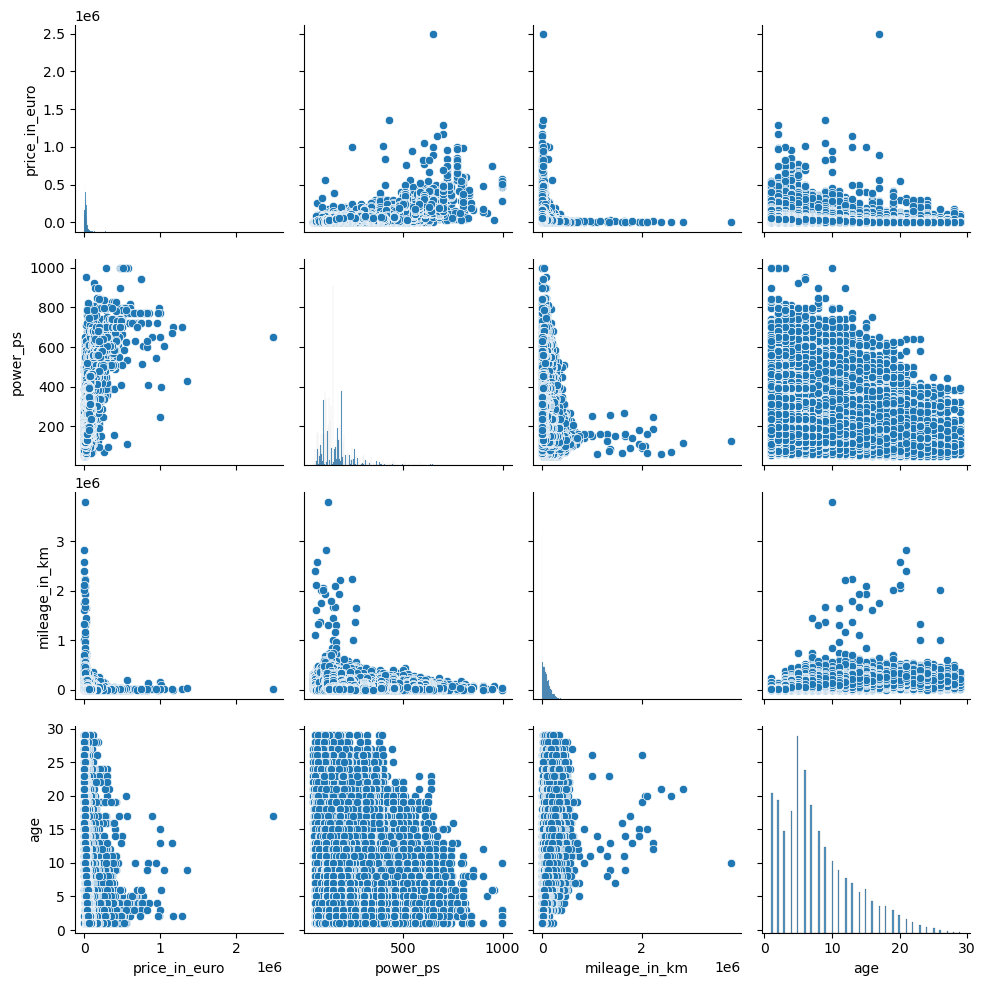

In [38]:
# Define the subset and pairplot
sub = df_filtered[['price_in_euro', 'power_ps', 'mileage_in_km', 'age']]

g = sns.pairplot(sub)
plt.savefig(os.path.join(path, '04 Visualizations', 'pairplot.png'))


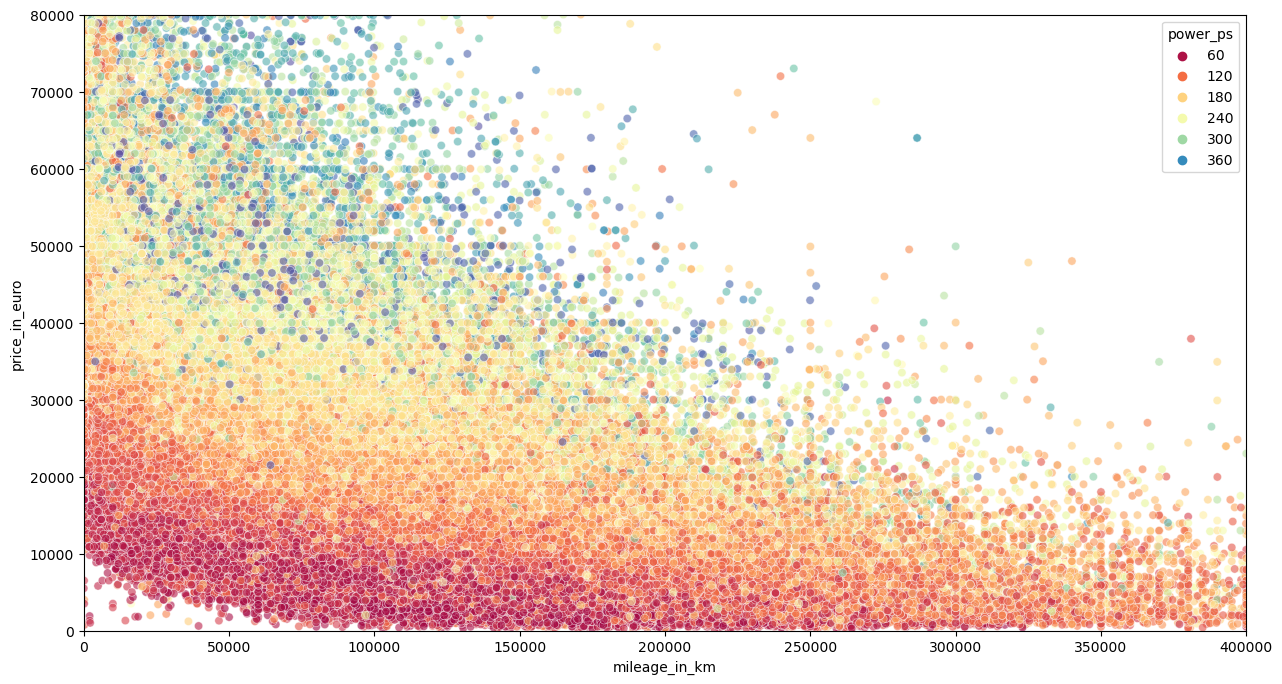

In [39]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_filtered[df_filtered['power_ps']<400],x='mileage_in_km',y='price_in_euro', hue='power_ps',alpha=0.6, palette='Spectral')
plt.xlim(0, 400000)
plt.ylim(0, 80000)
pmG = os.path.join(path,  '04 Visualizations', 'Powe_mileagr_price.png')
# Save the figure
plt.savefig(pmG)
plt.show()

# fuel Type  

In [40]:
# Calculate the counts of each fuel type
fuel_counts = df_filtered['fuel_type'].value_counts()
fuel_counts

fuel_type
Petrol           139428
Diesel            83813
Hybrid            12173
LPG                1141
Electric           1063
CNG                 491
Diesel Hybrid       461
Hydrogen             63
Name: count, dtype: int64

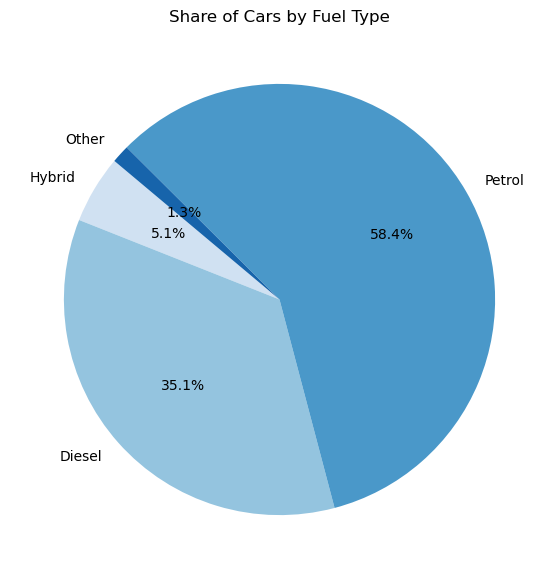

In [41]:
# Sort the fuel types by counts (largest to smallest)
sorted_fuel_counts = fuel_counts.sort_values(ascending=True)

# Create an "Other" category for less common fuels
threshold = 2000
other_count = sorted_fuel_counts[sorted_fuel_counts < threshold].sum()
sorted_fuel_counts = sorted_fuel_counts[sorted_fuel_counts >= threshold]
sorted_fuel_counts['Other'] = other_count

# Define a custom palette with varying shades of blue
custom_palette = sns.color_palette('Blues', n_colors=len(sorted_fuel_counts))

# Create the pie chart
plt.figure(figsize=(10, 7))
plt.pie(sorted_fuel_counts, labels=sorted_fuel_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Share of Cars by Fuel Type')
plt.savefig(os.path.join(path, '04 Visualizations', 'Fuel-dis.png'))
plt.show()

# Transmission

In [42]:
# Calculate the counts of transmission type
transmission_counts = df_filtered['transmission_type'].value_counts()
transmission_counts

transmission_type
Automatic    123918
Manual       114715
Name: count, dtype: int64

# Colors

In [43]:
# Calculate the counts of each fuel type
color_counts = df_filtered['color'].value_counts()
color_counts

color
black     55925
grey      44488
white     38401
silver    33095
blue      30230
red       20342
brown      4270
orange     3236
green      3218
beige      2302
yellow     1652
bronze      562
gold        542
violet      370
Name: count, dtype: int64

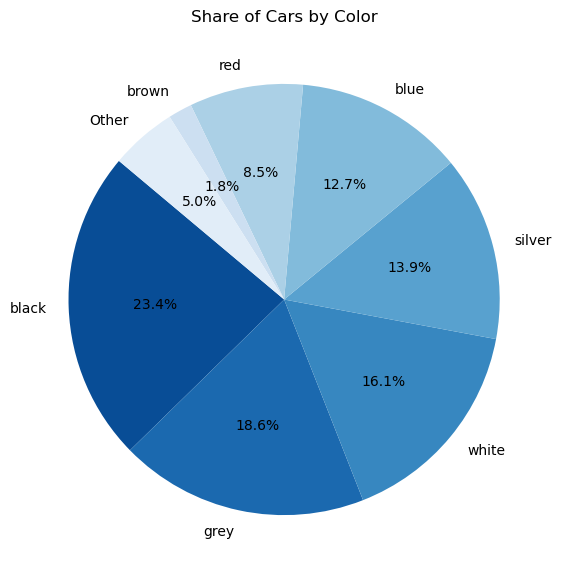

In [44]:
# Sort the colors by counts (largest to smallest)
sorted_color_counts = color_counts.sort_values(ascending=False)

# Create an "Other" category for less common colors
threshold =4000
other_count = sorted_color_counts[sorted_color_counts < threshold].sum()
sorted_color_counts = sorted_color_counts[sorted_color_counts >= threshold]
sorted_color_counts['Other'] = other_count

# Define a custom palette with varying shades of blue, reversed
custom_palette = sns.color_palette('Blues_r', n_colors=len(sorted_color_counts))

# Create the pie chart with the reversed palette
plt.figure(figsize=(10, 7))
plt.pie(sorted_color_counts, labels=sorted_color_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Share of Cars by Color')
plt.savefig(os.path.join(path, '04 Visualizations', 'color-dis.png'))
plt.show()

# Preparing Data For Regression Analysis

In [45]:
#reshape variables for regression 
X= df_filtered['power_ps'].values.reshape(-1, 1)
y = df_filtered['price_in_euro'].values.reshape(-1, 1)

In [46]:
X

array([[201.],
       [150.],
       [150.],
       ...,
       [235.],
       [197.],
       [179.]])

In [47]:
y

array([[ 1300.],
       [ 4900.],
       [ 7900.],
       ...,
       [89690.],
       [61521.],
       [57890.]])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Regression Analysis

In [55]:

# Create linear regression object
regression = LinearRegression()

# Fit regression to the training set
regression.fit(X_train, y_train)

# Predict on the testing set
y_predicted = regression.predict(X_test)

# Calculate the mean squared error and convert it to root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))  # This is the root mean squared error

# Calculate the R2 score
r2 = r2_score(y_test, y_predicted)  # This is the R2 score

# Print the model summary statistics
print('Slope:', regression.coef_)
print('Root mean squared error:', rmse)
print('R2 score:', r2)

Slope: [[222.64176675]]
Root mean squared error: 25678.701538116133
R2 score: 0.4198606429768683


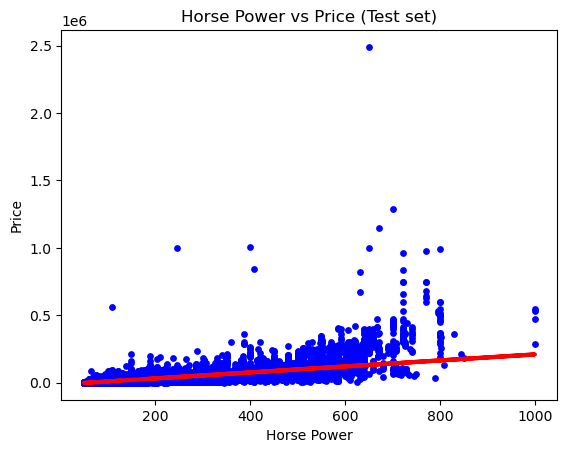

In [52]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='blue', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Horse Power vs Price (Test set)')
plot_test.xlabel('Horse Power')
plot_test.ylabel('Price')
regression = os.path.join(path,  '04 Visualizations', 'regression.png')
# Save the figure
plt.savefig(regression)

plot_test.show()

In [56]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,9999.0,29963.027806
1,16490.0,43321.533811
2,22650.0,16827.163568
3,86875.0,101208.393165
4,18990.0,16827.163568
5,5300.0,19498.864769
6,8999.0,10147.910566
7,14500.0,7698.851131
8,155555.0,87627.245393
9,299000.0,149076.373015


### The result indicated that the model predicts relatively higher numbers and can not be used.

# Elbow Technique

In [57]:
numeric_df = df_filtered.drop(columns=['brand', 'model', 'color', 'year', 'transmission_type','fuel_type'])

In [58]:
numeric_df

,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,age
0,1300.0,201.0,10.9,160500.0,29.0
3,4900.0,150.0,9.5,189500.0,29.0
5,7900.0,150.0,9.5,47307.0,28.0
9,6976.0,150.0,9.2,99000.0,28.0
10,5499.0,192.0,11.1,157000.0,28.0
...,...,...,...,...,...
251073,54500.0,197.0,5.6,5900.0,1.0
251074,57990.0,261.0,1.8,1229.0,1.0
251075,89690.0,235.0,7.6,4900.0,1.0
251076,61521.0,197.0,4.7,1531.0,1.0


In [59]:
numeric_df.dtypes

price_in_euro               float64
power_ps                    float64
fuel_consumption_l_100km    float64
mileage_in_km               float64
age                         float64
dtype: object

In [60]:
from sklearn.preprocessing import MinMaxScaler
# standardize Create a MinMaxScaler object
scaler = MinMaxScaler()

# Standardize the dataset
scaled_data = scaler.fit_transform(numeric_df)

# Convert the scaled data back to a DataFrame 
df_s = pd.DataFrame(scaled_data, columns=numeric_df.columns)

In [61]:
num_cl = range(1, 10) 
kmeans = [KMeans(n_clusters=i) for i in num_cl] 

In [62]:
score = [kmeans[i].fit(df_s).score(df_s) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.

score

E:\Users\poury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Users\poury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Users\poury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Users\poury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

[-11441.053883419194,
 -5252.075326723257,
 -3903.5063873227127,
 -2637.0511310690354,
 -2079.0616708838866,
 -1803.7592252374739,
 -1549.8669711956563,
 -1382.911854882865,
 -1247.2005590422327]

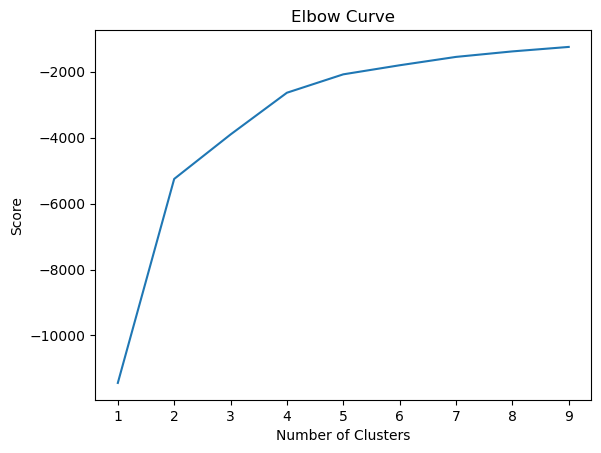

In [63]:
# Plot the elbow curve using PyLab.

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.savefig(path)
pl.show()

# KMeans Clustering

In [64]:
# Create the k-means object.

kmeans = KMeans(n_clusters = 4) 

In [65]:
# Fit the k-means object to the data.

kmeans.fit(df_s)

E:\Users\poury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [66]:
#attaching cluster column to dataframe
numeric_df['clusters'] = kmeans.fit_predict(df_s)

E:\Users\poury\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [67]:
numeric_df.tail()

,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km,age,clusters
251073,54500.0,197.0,5.6,5900.0,1.0,1
251074,57990.0,261.0,1.8,1229.0,1.0,1
251075,89690.0,235.0,7.6,4900.0,1.0,1
251076,61521.0,197.0,4.7,1531.0,1.0,1
251077,57890.0,179.0,1.8,1500.0,1.0,1


In [68]:
numeric_df['clusters'].value_counts()

clusters
1    110901
0     73220
2     36468
3     18044
Name: count, dtype: int64

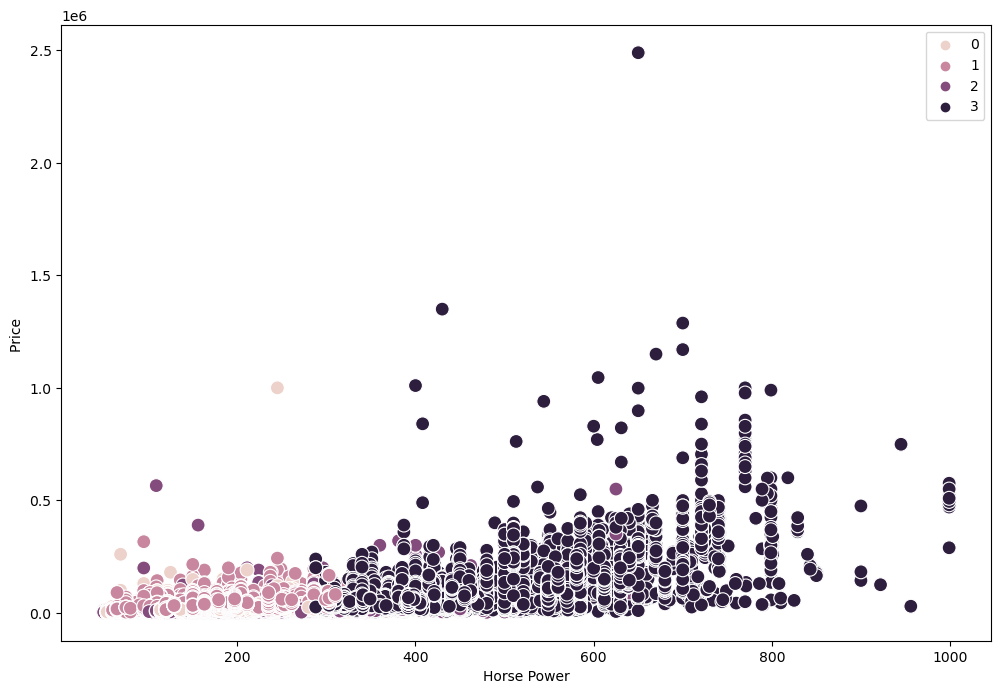

In [69]:
# Plot the clusters for the "Price" and "Horse Power" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=numeric_df['power_ps'], y=numeric_df['price_in_euro'], hue=kmeans.labels_, s=100) 

ax.grid(False) # remove background.
plt.xlabel('Horse Power') # Label x-axis.
plt.ylabel('Price ') # Label y-axis.
plt.savefig(os.path.join(path, '04 Visualizations', 'scatter-cluster.png'))
plt.show()

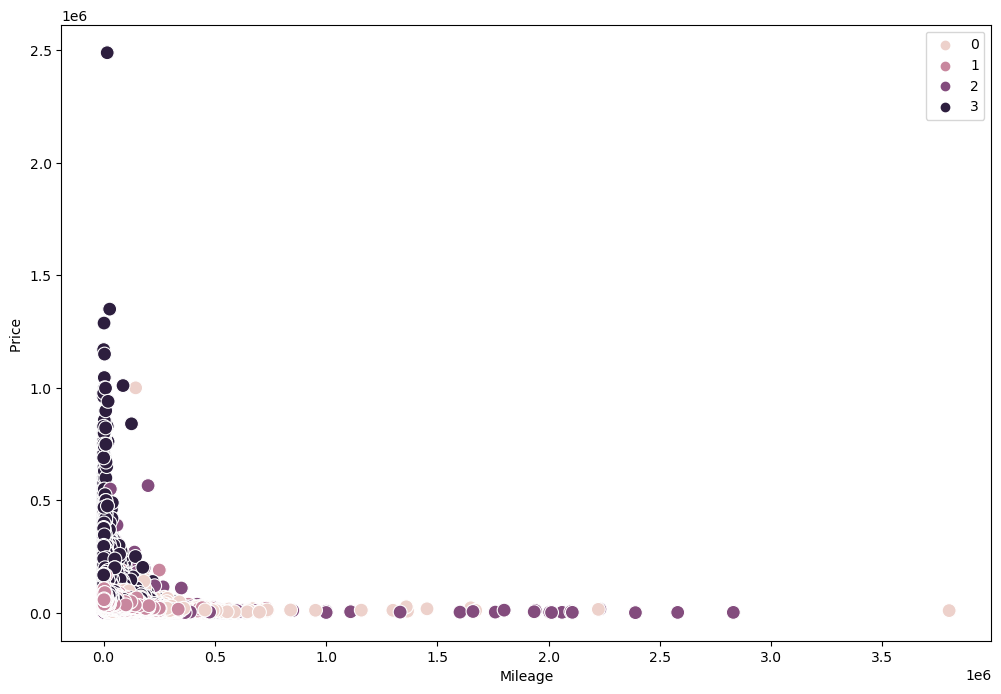

In [70]:
# Plot the clusters for the "Price" and "Mileage" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=numeric_df['mileage_in_km'], y=numeric_df['price_in_euro'], hue=kmeans.labels_, s=100) 

ax.grid(False) # remove background.
plt.xlabel('Mileage') # Label x-axis.
plt.ylabel('Price ') # Label y-axis.
plt.savefig(os.path.join(path, '04 Visualizations', 'scatter-cluster_2.png'))
plt.show()

In [71]:
numeric_df.loc[numeric_df['clusters'] == 3, 'cluster'] = 'dark purple'
numeric_df.loc[numeric_df['clusters'] == 2, 'cluster'] = 'purple'
numeric_df.loc[numeric_df['clusters'] == 1, 'cluster'] = 'pink'
numeric_df.loc[numeric_df['clusters'] == 0, 'cluster'] = 'schwarz'

In [72]:
numeric_df.groupby('clusters').agg({'price_in_euro':['mean', 'median'], 
                         'age':['mean', 'median'], 
                         'power_ps':['mean', 'median'],
                          'price_in_euro':['mean', 'median'],'mileage_in_km':['mean', 'median']})

price_in_euro                 age           power_ps         \
                  mean   median       mean median        mean median   
clusters                                                               
0         16043.818342  14488.0   9.429323    9.0  148.747009  140.0   
1         27987.791589  24999.0   3.655287    4.0  150.184119  150.0   
2          8045.249644   5500.0  17.695569   17.0  146.202671  136.0   
3         84029.202560  57000.0   5.771669    6.0  422.842274  400.0   

          mileage_in_km            
                   mean    median  
clusters                           
0         117937.953087  106500.0  
1          38001.728388   28400.0  
2         180418.732396  173000.0  
3          60261.762580   50000.0

In [73]:
# Export data to csv

numeric_df.to_csv(os.path.join(path, '02 Data','Prepared Data', 'cluster_Auto Scout Cleaned.csv'))

# Adding Flags

### Price Flag 

In [74]:
bins = [0, 10000, 20000, 50000, 150000, float('inf')]
labels = ['Low Price', 'Mid-Range', 'Expensive', 'Luxury', 'Super Cars']

# Create a new column for price flags
df_filtered['price_flag'] = pd.cut(df_filtered['price_in_euro'], bins=bins, labels=labels, right=False)

print(df_filtered[['price_in_euro', 'price_flag']].head())

    price_in_euro price_flag
0          1300.0  Low Price
3          4900.0  Low Price
5          7900.0  Low Price
9          6976.0  Low Price
10         5499.0  Low Price


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\4176323768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['price_flag'] = pd.cut(df_filtered['price_in_euro'], bins=bins, labels=labels, right=False)


### Power Flag

In [75]:
# Define bins for horsepower categories
power_bins = [0, 100, 200, 300, 400, float('inf')]
power_labels = ['Low Power', 'Moderate Power', 'High Power', 'Performance', 'Super Performance']

# Create a new column for horsepower flags
df_filtered['power_flag'] = pd.cut(df_filtered['power_ps'], bins=power_bins, labels=power_labels, right=False)

print(df_filtered[['power_ps', 'power_flag']].head())

    power_ps      power_flag
0      201.0      High Power
3      150.0  Moderate Power
5      150.0  Moderate Power
9      150.0  Moderate Power
10     192.0  Moderate Power


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\2485226245.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['power_flag'] = pd.cut(df_filtered['power_ps'], bins=power_bins, labels=power_labels, right=False)


### Age Flag

In [76]:
# Define bins for age categories 
age_bins = [0, 3, 5, 10, 20, 30, float('inf')]
age_labels = ['New', 'Mostly New', 'Moderate', 'Old', 'Very Old', 'Ancient']

# Create a new column for age flags
df_filtered['age_flag'] = pd.cut(df_filtered['age'], bins=age_bins, labels=age_labels, right=False)

print(df_filtered[['age', 'age_flag']].head())

     age  age_flag
0   29.0  Very Old
3   29.0  Very Old
5   28.0  Very Old
9   28.0  Very Old
10  28.0  Very Old


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\1314326259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age_flag'] = pd.cut(df_filtered['age'], bins=age_bins, labels=age_labels, right=False)


### Consumption Flag

In [77]:
# Define bins for fuel consumption categories (in L/100km)
consumption_bins = [0, 5, 8, 12, float('inf')]
consumption_labels = ['Low', 'Moderate', 'High', 'Very High']

# Create a new column for consumption flags
df_filtered['consumption_flag'] = pd.cut(df_filtered['fuel_consumption_l_100km'], bins=consumption_bins, labels=consumption_labels, right=False)

print(df_filtered[['fuel_consumption_l_100km', 'consumption_flag']].head())


    fuel_consumption_l_100km consumption_flag
0                       10.9             High
3                        9.5             High
5                        9.5             High
9                        9.2             High
10                      11.1             High


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\3352239472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['consumption_flag'] = pd.cut(df_filtered['fuel_consumption_l_100km'], bins=consumption_bins, labels=consumption_labels, right=False)


### Mileage Flag

In [78]:
# Define the bins and labels for mileage flags
mileage_bins = [0,10000, 50000, 100000, 200000, 250000, np.inf]
mileage_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extreme']

# Create a new column for mileage flags
df_filtered['mileage_flag'] = pd.cut(df_filtered['mileage_in_km'], bins=mileage_bins, labels=mileage_labels, right=False)

# Display the first few rows to verify the new column
print(df_filtered[['mileage_in_km', 'mileage_flag']].head())

    mileage_in_km mileage_flag
0        160500.0         High
3        189500.0         High
5         47307.0          Low
9         99000.0     Moderate
10       157000.0         High


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\250929651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mileage_flag'] = pd.cut(df_filtered['mileage_in_km'], bins=mileage_bins, labels=mileage_labels, right=False)


### Producer country Flag 

In [79]:
unique_brands = df_filtered['brand'].unique()
print(unique_brands)

['alfa-romeo' 'aston-martin' 'audi' 'bentley' 'bmw' 'cadillac' 'chevrolet'
 'chrysler' 'citroen' 'dacia' 'daewoo' 'daihatsu' 'dodge' 'ferrari' 'fiat'
 'ford' 'honda' 'hyundai' 'infiniti' 'isuzu' 'jaguar' 'jeep' 'kia' 'lada'
 'lamborghini' 'lancia' 'land-rover' 'maserati' 'mazda' 'mercedes-benz'
 'mini' 'mitsubishi' 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover'
 'saab' 'seat' 'skoda' 'smart' 'ssangyong' 'toyota' 'volkswagen' 'volvo']


In [80]:
# Dictionary mapping brands to producer countries
brand_country_mapping = {
    'alfa-romeo': 'Italy',
    'aston-martin': 'United Kingdom',
    'audi': 'Germany',
    'bentley': 'United Kingdom',
    'bmw': 'Germany',
    'cadillac': 'United States',
    'chevrolet': 'United States',
    'chrysler': 'United States',
    'citroen': 'France',
    'dacia': 'Romania',
    'daewoo': 'South Korea',
    'daihatsu': 'Japan',
    'dodge': 'United States',
    'ferrari': 'Italy',
    'fiat': 'Italy',
    'ford': 'United States',
    'honda': 'Japan',
    'hyundai': 'South Korea',
    'infiniti': 'Japan',
    'isuzu': 'Japan',
    'jaguar': 'United Kingdom',
    'jeep': 'United States',
    'kia': 'South Korea',
    'lada': 'Russia',
    'lamborghini': 'Italy',
    'lancia': 'Italy',
    'land-rover': 'United Kingdom',
    'maserati': 'Italy',
    'mazda': 'Japan',
    'mercedes-benz': 'Germany',
    'mini': 'United Kingdom',
    'mitsubishi': 'Japan',
    'nissan': 'Japan',
    'opel': 'Germany',
    'peugeot': 'France',
    'porsche': 'Germany',
    'renault': 'France',
    'rover': 'United Kingdom',
    'saab': 'Sweden',
    'seat': 'Spain',
    'skoda': 'Czech Republic',
    'smart': 'Germany',
    'ssangyong': 'South Korea',
    'toyota': 'Japan',
    'volkswagen': 'Germany',
    'volvo': 'Sweden'
}

# Add the producer country column based on brand
df_filtered['producer_country'] = df_filtered['brand'].map(brand_country_mapping)

print(df_filtered[['brand', 'producer_country']].head())

         brand producer_country
0   alfa-romeo            Italy
3   alfa-romeo            Italy
5   alfa-romeo            Italy
9   alfa-romeo            Italy
10  alfa-romeo            Italy


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\3544560040.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['producer_country'] = df_filtered['brand'].map(brand_country_mapping)


In [81]:
# Dictionary mapping brands to parent companies
brand_parent_mapping = {
    'alfa-romeo': 'Stellantis',
    'aston-martin': 'Independent',
    'audi': 'Volkswagen Group',
    'bentley': 'Volkswagen Group',
    'bmw': 'Independent',
    'cadillac': 'General Motors',
    'chevrolet': 'General Motors',
    'chrysler': 'Stellantis',
    'citroen': 'Stellantis',
    'dacia': 'Renault Group',
    'daewoo': 'Independent',
    'daihatsu': 'Toyota',
    'dodge': 'Stellantis',
    'ferrari': 'Independent',
    'fiat': 'Stellantis',
    'ford': 'Ford Motor Company',
    'honda': 'Honda',
    'hyundai': 'Hyundai Motor Group',
    'infiniti': 'Nissan',
    'isuzu': 'Independent',
    'jaguar': 'Tata Motors',
    'jeep': 'Stellantis',
    'kia': 'Hyundai Motor Group',
    'lada': 'AvtoVAZ',
    'lamborghini': 'Volkswagen Group',
    'lancia': 'Stellantis',
    'land-rover': 'Tata Motors',
    'maserati': 'Stellantis',
    'mazda': 'Independent',
    'mercedes-benz': 'Daimler AG',
    'mini': 'BMW',
    'mitsubishi': 'Renault-Nissan-Mitsubishi Alliance',
    'nissan': 'Renault-Nissan-Mitsubishi Alliance',
    'opel': 'Stellantis',
    'peugeot': 'Stellantis',
    'porsche': 'Volkswagen Group',
    'renault': 'Renault Group',
    'rover': 'Tata Motors',
    'saab': 'Independent',
    'seat': 'Volkswagen Group',
    'skoda': 'Volkswagen Group',
    'smart': 'Daimler AG',
    'ssangyong': 'Mahindra & Mahindra',
    'toyota': 'Toyota',
    'volkswagen': 'Volkswagen Group',
    'volvo': 'Geely'
}

# Add the parent company column based on brand
df_filtered['parent_company'] = df_filtered['brand'].map(brand_parent_mapping)

print(df_filtered[['brand', 'parent_company']].head())

         brand parent_company
0   alfa-romeo     Stellantis
3   alfa-romeo     Stellantis
5   alfa-romeo     Stellantis
9   alfa-romeo     Stellantis
10  alfa-romeo     Stellantis


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\939972194.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['parent_company'] = df_filtered['brand'].map(brand_parent_mapping)


In [82]:
df_filtered['parent_company'].value_counts()

parent_company
Volkswagen Group                      82487
Stellantis                            37894
Daimler AG                            27193
Independent                           24192
Ford Motor Company                    17854
Hyundai Motor Group                   12081
Renault Group                         10950
Toyota                                 7995
Renault-Nissan-Mitsubishi Alliance     4269
Tata Motors                            4261
BMW                                    4059
Geely                                  3930
Honda                                   749
Mahindra & Mahindra                     292
General Motors                          189
AvtoVAZ                                 168
Nissan                                   70
Name: count, dtype: int64

E:\Users\poury\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


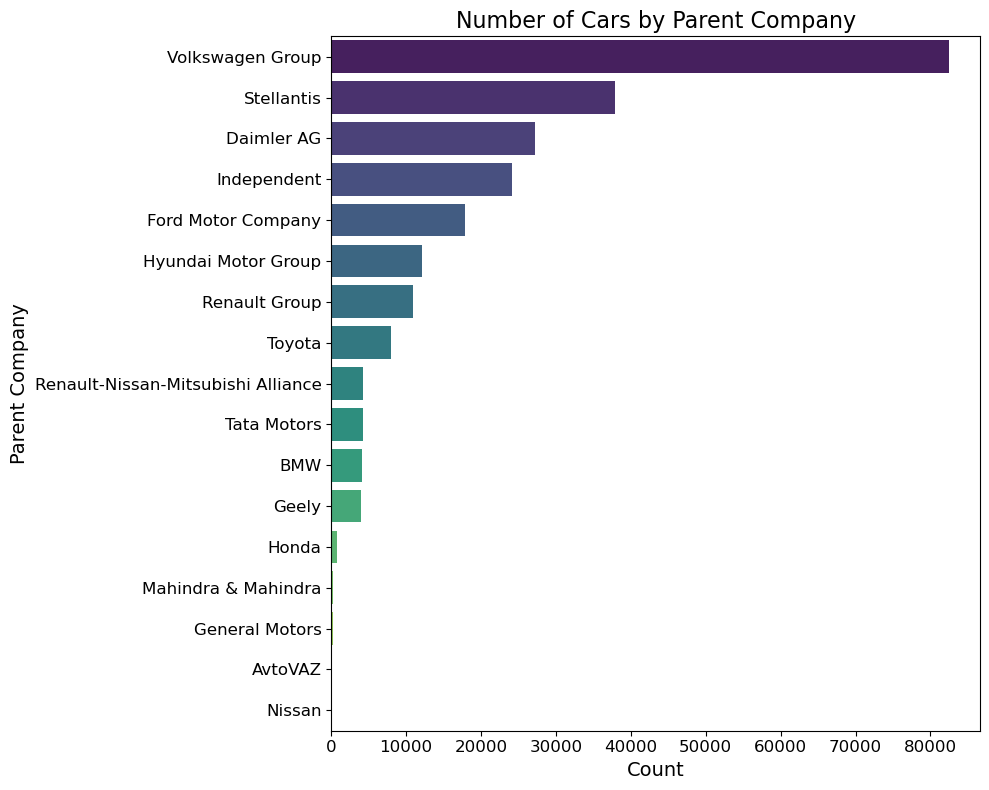

In [83]:
# Data
parent_companies = [
    'Volkswagen Group', 'Stellantis', 'Daimler AG', 'Independent',
    'Ford Motor Company', 'Hyundai Motor Group', 'Renault Group',
    'Toyota', 'Renault-Nissan-Mitsubishi Alliance', 'Tata Motors',
    'BMW', 'Geely', 'Honda', 'Mahindra & Mahindra', 'General Motors',
    'AvtoVAZ', 'Nissan'
]
counts = [
    82487, 37894, 27193, 24192, 17854, 12081, 10950, 7995, 4269, 4261,
    4059, 3930, 749, 292, 189, 168, 70
]

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=counts, y=parent_companies, palette='viridis')  # Adjusted color palette for a professional look
plt.xlabel('Count', fontsize=14)  # Increased font size for clarity
plt.ylabel('Parent Company', fontsize=14)  # Increased font size for clarity
plt.title('Number of Cars by Parent Company', fontsize=16)  # Increased font size for clarity
plt.xlim(0, max(counts) * 1.05)  # Setting limit for x-axis to accommodate the largest value
plt.xticks(fontsize=12)  # Increased font size for x-axis ticks
plt.yticks(fontsize=12)  # Increased font size for y-axis ticks
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.savefig(os.path.join(path, '04 Visualizations', 'parent_comp.png'))
plt.show()

### Combis

In [84]:
# Convert categorical columns to strings
df_filtered['price_flag'] = df_filtered['price_flag'].astype(str)
df_filtered['mileage_flag'] = df_filtered['mileage_flag'].astype(str)

# Define the combinations of flags
df_filtered['price_mileage_flag'] = df_filtered['price_flag'] + '_' + df_filtered['mileage_flag'] + ' Mileage'

# Display the first few rows to verify the new column
print(df_filtered[['price_flag', 'mileage_flag', 'price_mileage_flag']].head())

   price_flag mileage_flag          price_mileage_flag
0   Low Price         High      Low Price_High Mileage
3   Low Price         High      Low Price_High Mileage
5   Low Price          Low       Low Price_Low Mileage
9   Low Price     Moderate  Low Price_Moderate Mileage
10  Low Price         High      Low Price_High Mileage


C:\Users\poury\AppData\Local\Temp\ipykernel_13444\379439112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['price_flag'] = df_filtered['price_flag'].astype(str)
C:\Users\poury\AppData\Local\Temp\ipykernel_13444\379439112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mileage_flag'] = df_filtered['mileage_flag'].astype(str)
C:\Users\poury\AppData\Local\Temp\ipykernel_13444\379439112.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [85]:
# Export data to csv

df_filtered.to_csv(os.path.join(path, '02 Data','Prepared Data', 'Flaged Data.csv'))

E:\Users\poury\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


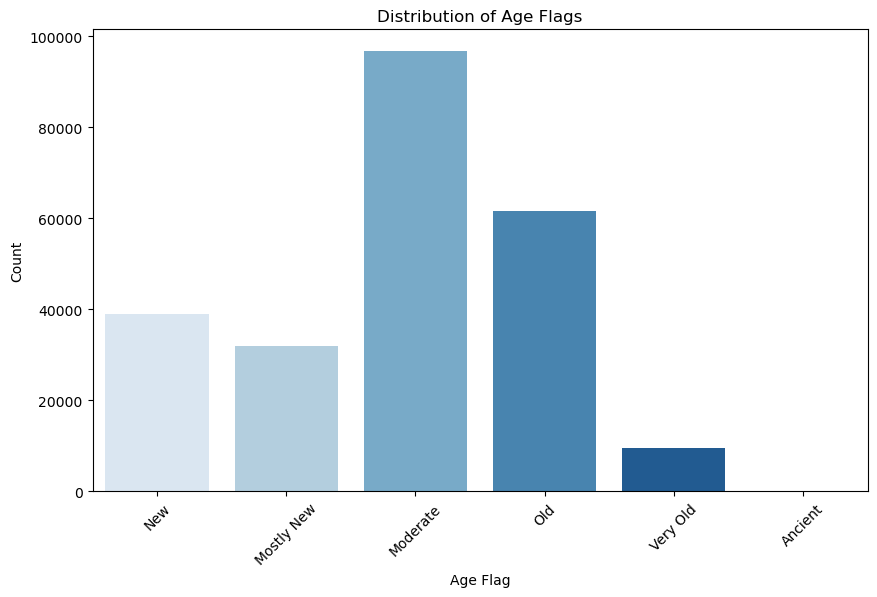

In [86]:
# Define a custom palette with different shades of blue
custom_palette = sns.color_palette("Blues", len(df_filtered['age_flag'].unique()))

# Plot the distribution of age flags with the custom color palette
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='age_flag', palette=custom_palette)
plt.title('Distribution of Age Flags')
plt.xlabel('Age Flag')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Comparing BMW and TOYOTA

In [87]:
# Filter the DataFrame for Toyota and BMW cars
toyota_cars = df_filtered[df_filtered['brand'] == 'toyota']
bmw_cars = df_filtered[df_filtered['brand'] == 'bmw']

# For simplicity, let's assume 'year' and 'mileage_in_km' are your independent variables and 'price_in_euro' is the dependent variable.

# Toyota
X_toyota = toyota_cars[['mileage_in_km', 'age']]
X_toyota = sm.add_constant(X_toyota)  # Adds a constant term to the predictor
y_toyota = toyota_cars['price_in_euro']

model_toyota = sm.OLS(y_toyota, X_toyota).fit()

# BMW
X_bmw = bmw_cars[['mileage_in_km', 'age']]
X_bmw = sm.add_constant(X_bmw)  # Adds a constant term to the predictor
y_bmw = bmw_cars['price_in_euro']

model_bmw = sm.OLS(y_bmw, X_bmw).fit()

# Print the summary of the regression results for both brands
print("Toyota Regression Results:")
print(model_toyota.summary())
print("\nBMW Regression Results:")
print(model_bmw.summary())

# Compare the coefficients for 'mileage_in_km' and 'year' between the two models


Toyota Regression Results:
                            OLS Regression Results                            
Dep. Variable:          price_in_euro   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     1787.
Date:                Tue, 27 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:13:49   Log-Likelihood:                -84973.
No. Observations:                7855   AIC:                         1.700e+05
Df Residuals:                    7852   BIC:                         1.700e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.34